# Natural Language Processing Tutorial

Author: Matthew K. MacLeod

## Tutorial Goals

* brief introduction
* explore NLP from scratch 
* starting from simple approaches to text processing
* contrast with more advanced approaches
    * viterbi
    * naive bayes
    * n gram models
    * statistical parsing
    * tf-idf
    * RNN
    * LSTM


## Procedure

This notebook will parse some classical literature texts and see if we can find anything interesting. 
This notebook should be **fully reproducible**, ie we will do _all_ these steps together:

* download data
* process data
* NLP exploration

I may use some code in the **pdapt**  library:

https://github.com/matthewmacleod/pdapt


Furthermore, use following tools as much as possible:

* command line tools
     * grep 
     * sed 
     * awk
     * tr
* regex
* Python
* our own code

## Introduction




First off let's go over some NLP linguistical jargon:

### terminology:
* **lemma**: same stem (**wordform** is the opposite of this)
* **type**:  a basic element of the vocabulary
* **vocabulary**: $|V|$, size of the type set
* **tokens**: an instance of a type in the text, often denoted $N$
* **morphemes**: smallest meaningful unit of word
    * **stems**: core meaning part 
    * **affixes**: additional parts (to yeild grammatical agreement)
* **stemming**: affix removal

NB: in general
    $|V| > \sqrt{N}$



### NLP Applications

* simple applications
    * spam detection
    * part of speech (**POS**) eg noun, adj, etc
    * named person recognition (**NER**) ie proper nouns
    
* medium difficulty applications
    * sentiment analysis (quantify the polarity of a subject)
    * parsing
    * word sense disambiguation (**WSD**)
    * information extraction (**IE**)
    * machine translation (**MT**) between languages    

* difficult tasks
    * question answering
    * paraphrasing
    * summarization
    * human-machine communication (dialog)


### General NLP Challenges

* ambiguity (multiple interpretations)
    * **case folding** is important and can cause problems if not done carefully, eg:
        * if one lowercases US to us now can be ambiguous
        * Fed to fed
* segmentation issues
    * eg sentence segmentation based on period (.), use decision tree
* idioms
* neologisms
* non-standard English (stuff found on the web)

when working with **_actual text_** have the following **general** challenges

* **type I errors**: false positives
    * match things we shouldn't match
    * eg when looking for **the**, also match o**the**r, O**the**llo, ect
* **type II errors**: false negatives
    * missing stuff we should have matched
    * eg when search for **the**, miss capitalized **The**

### Unique language challenges

Each language comes with it's own set of peculiarities. An incomplete list of examples:

English:
* contraction expansion
    
French:
* contraction expansion
* gender

German:
* compound splitting of nouns (also Turkish)

## Data Sources

Some sources from Peter Norvig and Beautiful data (some is already tokenized)

http://norvig.com/ngrams/

### Classical Literature 

#### Complete works:

Mostly undefiled Shakespeare (we will need to remove some header info so we can mine it accurately):

http://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt
    

from Project Gutenberg (http://www.gutenberg.org/):
   
Austen, complete works:
    
http://www.gutenberg.org/cache/epub/31100/pg31100.txt
    
Shelley, complete works:

http://www.gutenberg.org/cache/epub/4800/pg4800.txt
    
Aristotle, complete works:

http://www.gutenberg.org/cache/epub/12699/pg12699.txt

Plutarch:

http://www.gutenberg.org/cache/epub/3052/pg3052.txt

Walt Whitman, complete prose:

http://www.gutenberg.org/cache/epub/8813/pg8813.txt

Edgar Allan Poe, volumes:

http://www.gutenberg.org/files/2147/2147-0.txt

http://www.gutenberg.org/cache/epub/2148/pg2148.txt

http://www.gutenberg.org/cache/epub/2149/pg2149.txt

http://www.gutenberg.org/cache/epub/2150/pg2150.txt

http://www.gutenberg.org/cache/epub/2151/pg2151.txt


#### Selected works:

http://www.gutenberg.org/cache/epub/12699/pg12699.txt

Beyond Good and Evil, by Friedrich Nietzsche:

http://www.gutenberg.org/cache/epub/4363/pg4363.txt

in German:

http://www.gutenberg.org/cache/epub/7204/pg7204.txt


Zadig by Voltaire, in French:

http://www.gutenberg.org/cache/epub/4647/pg4647.txt




### NLP resources

https://en.wikipedia.org/wiki/Natural_language_processing

https://en.wikipedia.org/wiki/N-gram

https://en.wikipedia.org/wiki/Katz's_back-off_model

https://en.wikipedia.org/wiki/Good%E2%80%93Turing_frequency_estimation

https://en.wikipedia.org/wiki/Kneser%E2%80%93Ney_smoothing


### Download data

In [307]:
import os, sys

In [308]:
os.chdir('./data')

In [309]:
os.getcwd()

'/home/matej/develop/mkm_notebooks/data'

#### Shakespeare

In [70]:
# uncomment to download 
#!wget http://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt

In [5]:
!wc -l t8.shakespeare.txt

124456 t8.shakespeare.txt


#### Austen

In [71]:
#!wget http://www.gutenberg.org/cache/epub/31100/pg31100.txt

In [7]:
!wc -l pg31100.txt

80476 pg31100.txt


#### Others:

In [72]:
# other files Shelley
#!wget http://www.gutenberg.org/cache/epub/4800/pg4800.txt

In [73]:
# Aristotle
#!wget http://www.gutenberg.org/cache/epub/12699/pg12699.txt

In [74]:
# Poe
#!wget http://www.gutenberg.org/files/2147/2147-0.txt
#!wget http://www.gutenberg.org/cache/epub/2148/pg2148.txt
#!wget http://www.gutenberg.org/cache/epub/2149/pg2149.txt
#!wget http://www.gutenberg.org/cache/epub/2150/pg2150.txt
#!wget http://www.gutenberg.org/cache/epub/2151/pg2151.txt
#!mv 2147-0.txt pg2147.txt

In [337]:
# Plutarch
#!wget http://www.gutenberg.org/cache/epub/3052/pg3052.txt

In [339]:
# Whitman
#!wget http://www.gutenberg.org/cache/epub/8813/pg8813.txt

### Process files

In this section we clean the data. We need to remove headers and footers so we are left with only the authors text.

#### Shakespeare

let's check the data:

In [8]:
!grep -n SONNETS t8.shakespeare.txt

247:THE SONNETS


In [26]:
# get everything but the first 246 lines
!tail -n +246 t8.shakespeare.txt | head -n 20


THE SONNETS

by William Shakespeare



                     1
  From fairest creatures we desire increase,
  That thereby beauty's rose might never die,
  But as the riper should by time decease,
  His tender heir might bear his memory:
  But thou contracted to thine own bright eyes,
  Feed'st thy light's flame with self-substantial fuel,
  Making a famine where abundance lies,
  Thy self thy foe, to thy sweet self too cruel:
  Thou that art now the world's fresh ornament,
  And only herald to the gaudy spring,
  Within thine own bud buriest thy content,
  And tender churl mak'st waste in niggarding:
tail: error writing ‘standard output’: Broken pipe


In [10]:
# save the header edit 
!tail -n +246 t8.shakespeare.txt > temp.txt

In [11]:
# strip footer
!grep -n "THE END" temp.txt | tail

99210:THE END
102255:THE END
104915:THE END
107783:THE END
110792:THE END
114791:THE END
117608:THE END
120181:THE END
123792:THE END
124193:THE END


In [12]:
!head -n 124193 temp.txt | tail


  'O, that infected moisture of his eye,
  O, that false fire which in his cheek so glowed,
  O, that forced thunder from his heart did fly,
  O, that sad breath his spongy lungs bestowed,
  O, all that borrowed motion, seeming owed,
  Would yet again betray the fore-betrayed,
  And new pervert a reconciled maid.'

THE END


In [13]:
!head -n 124193 temp.txt > shakespeare.txt

#### Austen

In [14]:
!grep -n Chapter pg31100.txt | head -n 1

In [15]:
!tail -n +90 pg31100.txt | head











tail: error writing ‘standard output’: Broken pipe


In [16]:
!tail -n +90 pg31100.txt > temp.txt

In [17]:
!grep -n "End of the Project Gutenberg" temp.txt

In [18]:
!head -n 80023 temp.txt > austen.txt

#### Other Authors

this is a bit tedious so write a script:

In [320]:
!cat clean_gutenberg.sh

#!/bin/bash

# Matthew K. MacLeod
# January 4th 2016

# Simple script strips header and footer from
# a Project Gutenberg text so basic NLP analysis
# on authors work can be preformed.

# usage, supply text and target:
#  ./clean_gutenberg.sh pg31100.txt austen
# output:
#  austen.txt
#

if [ $# -eq 0 ] ; then
  echo "No arguments supplied; give text and target name"
  exit
fi

text=$1
author=$2

# get start line
start=`grep -n "START OF THIS PROJECT GUTENBERG" $text | awk '{print $1}' | sed 's/\:\*\*\*//'`
start=$((start+10))
# send the rest of text from start down to temp.txt
tail -n +$start $text > temp.txt
# clean up footer
end=`grep -n "End of the Project Gutenberg"  temp.txt | awk '{print $1}' | sed 's/\:End//'`
end=$((end-1))
# save final text
head -n $end temp.txt > $author.txt
echo "New lines: " `wc -l $author.txt`




In [321]:
!pwd
!./clean_gutenberg.sh pg4800.txt shelley

/home/matej/develop/mkm_notebooks/data
New lines:  59256 shelley.txt


In [322]:
!./clean_gutenberg.sh pg12699.txt aristotle

New lines:  11334 aristotle.txt


In [323]:
!./clean_gutenberg.sh pg2147.txt poe1
!./clean_gutenberg.sh pg2148.txt poe2
!./clean_gutenberg.sh pg2149.txt poe3
!./clean_gutenberg.sh pg2150.txt poe4
!./clean_gutenberg.sh pg2151.txt poe5
!cp poe1.txt poe.txt; cat poe2.txt >> poe.txt; cat poe3.txt >> poe.txt; cat poe4.txt >>poe.txt; cat poe5.txt >>poe.txt 
!wc -l poe.txt

New lines:  9195 poe1.txt
New lines:  9834 poe2.txt
New lines:  9606 poe3.txt
New lines:  8507 poe4.txt
New lines:  10284 poe5.txt
47426 poe.txt


In [340]:
!./clean_gutenberg.sh pg3052.txt plutarch

New lines:  30216 plutarch.txt


In [341]:
!./clean_gutenberg.sh pg8813.txt whitman

New lines:  24330 whitman.txt


## Exploration

### Simple analysis

let's see some vocabulary sizes..this is an extremely simple word count analysis but is part of more complicated approaches. (Starting with Uni-gram models, bag of words).

#### The Bard's bag

In [324]:
# map nonwords to newlines
!tr -sc 'A-Za-z' '\n' < shakespeare.txt | head


THE
SONNETS
by
William
Shakespeare
From
fairest
creatures
we
tr: write error: Broken pipe
tr: write error


In [325]:
# sort on alphabetical order:
!tr -sc 'A-Za-z' '\n' < shakespeare.txt | sort | uniq -c | head

      1 
  12780 a
   1945 A
     25 Aaron
     72 AARON
      1 abaissiez
     10 abandon
      2 abandoned
      2 abase
      1 abash
uniq: write error: Broken pipe


In [326]:
# sort the lexicon on freq
!tr -sc 'A-Za-z' '\n' < shakespeare.txt | sort | uniq -c | sort -n -r | head -n 20

  23243 the
  22225 I
  18618 and
  16339 to
  15687 of
  12780 a
  12163 you
  10839 my
  10005 in
   8954 d
   8394 is
   8333 that
   8035 not
   7752 me
   7486 s
   7457 And
   6798 with
   6750 it
   6401 be
   6322 his
sort: write failed: standard output: Broken pipe
sort: write error


In [327]:
# map case to lower, sort on freq
!tr -sc 'A-Za-z' '\n' < shakespeare.txt | tr 'A-Z' 'a-z' |  sort | uniq -c | sort -n -r | head -n 20

  27595 the
  26735 and
  22538 i
  19771 to
  18132 of
  14725 a
  13826 you
  12489 my
  11535 that
  11112 in
   9753 is
   8960 d
   8729 not
   8306 for
   8008 with
   7777 me
   7725 it
   7721 s
   7114 be
   6874 your
sort: write failed: standard output: Broken pipe
sort: write error


#### Shakespeare's vocabulary size

In [365]:
# Shakespeare's vocabulary size:
shakespeare = !tr -sc 'A-Za-z' '\n' < shakespeare.txt | tr 'A-Z' 'a-z' |  sort | uniq -c | sort -n -r | wc -l
shakespeare_vocab_count = int(shakespeare[0])
shakespeare_vocab_count

23529

#### Discussion 

This is quite large! He is famous for creating new words. Actually, there are many that we still use today, eg _all_ words starting with the prefix '**un**', eg **un**just.

https://en.wikipedia.org/wiki/William_Shakespeare

http://www.shakespeareswords.com/FEW

Although this quick and dirty command line magic doesn't agree exactly with previous estimates (if I recall should be more like 29K). In anycase we will processed the files identically so the relative differences may be more meaningful.

Shakespeare skepticism:

https://www.bostonglobe.com/ideas/2013/08/17/coined-shakespeare-think-again/tWFE6b8qTD5gnybL5fOn8H/story.html


Foreshadowing while we're on the subject of skepticism:

There have been accounts that Shakespare and Austen may have had help with their texts...this may be an interesting NLP project for later in this notebook.


#### Some Other Vocabulary sizes

In [355]:
# Austen
austen = !tr -sc 'A-Za-z' '\n' < austen.txt | tr 'A-Z' 'a-z' |  sort | uniq -c | sort -n -r | wc -l
austen_vocab_count = int(austen[0])
austen_vocab_count

14638

In [356]:
# Shelley
shelley = !tr -sc 'A-Za-z' '\n' < shelley.txt | tr 'A-Z' 'a-z' |  sort | uniq -c | sort -n -r | wc -l
shelley_vocab_count = int(shelley[0])
shelley_vocab_count 

19537

In [357]:
# Aristotle
aristotle = !tr -sc 'A-Za-z' '\n' < aristotle.txt | tr 'A-Z' 'a-z' |  sort | uniq -c | sort -n -r | wc -l
aristotle_vocab_count = int(aristotle[0])
aristotle_vocab_count

7240

In [358]:
# Poe
poe = !tr -sc 'A-Za-z' '\n' < poe.txt | tr 'A-Z' 'a-z' |  sort | uniq -c | sort -n -r | wc -l
poe_vocab_count = int(poe[0])
poe_vocab_count 

22192

In [360]:
# Plutarch
plutarch = !tr -sc 'A-Za-z' '\n' < plutarch.txt | tr 'A-Z' 'a-z' |  sort | uniq -c | sort -n -r | wc -l
plutarch_vocab_count = int(plutarch[0])
plutarch_vocab_count 

15426

In [363]:
# Whitman
whitman = !tr -sc 'A-Za-z' '\n' < whitman.txt | tr 'A-Z' 'a-z' |  sort | uniq -c | sort -n -r | wc -l
whitman_vocab_count = int(whitman[0])
whitman_vocab_count

17426

#### vocabulary size results

In [303]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [374]:
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12.0, 8.0)

In [366]:
bards = np.array(['Shakespeare','Austen','Shelley','Poe','Aristotle','Plutarch','Whitman'])
vocabs = np.array([shakespeare_vocab_count, austen_vocab_count, shelley_vocab_count, poe_vocab_count, aristotle_vocab_count, plutarch_vocab_count,whitman_vocab_count])

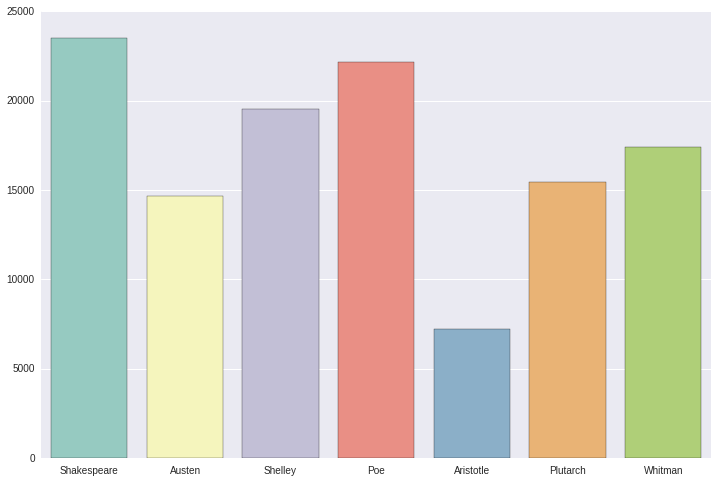

In [375]:
sns.barplot(bards,vocabs, palette="Set3")

The Aristotle vocabulary size is suspiciously low...maybe we have a **_lost in translation_** issue. To resolve this one simply needs to find his complete works in Greek and then compare the counts.

### Python version

Now let's do the same with python, first simple example

In [13]:
text="Thy self thy foe to thy sweet self too cruel"
words=text.split(" ")
print(words)

['Thy', 'self', 'thy', 'foe', 'to', 'thy', 'sweet', 'self', 'too', 'cruel']


In [5]:
uniq_words = list(set(words))
uniq_words

['to', 'too', 'Thy', 'cruel', 'thy', 'foe', 'self', 'sweet']

In [302]:
len(uniq_words)

8

## Probalistic Models

The simplest of these models predict the probability of a word, phrase, or sentence with basic probabilty. For example, the probabilty of a sentence (S) given the following words is given by the chain rule:

$P(S) = P(w_1, w_2,...w_n) = P(w_1)P(w_2|w_1)P(w_3|w_1,w_2)...P(w_n|w_1...w_{n-1})= \prod_i P(w_i|w_1w_2...w_{i-1})$






### Chain Rule for Shakespeare

For example, from the segment

"Thy self thy foe to thy sweet self too cruel"
 
The probablity of the first four words is

$P(\mathrm{Thy\ self\ thy\ foe}) = P(\mathrm{Thy}) P(\mathrm{self}|\mathrm{Thy}) P(\mathrm{thy}|\mathrm{Thy\ self}) P(\mathrm{foe}|\mathrm{Thy\ self\ thy})$



### Next word probability

The Shannon game of predicting the next word ($w_n$) is simply the conditional probability:

$P(w_n|w_1,...w_{n-1})$

ie what the probablity of $w_n$ given the previous sequence.


### Simplifying assumptions:

 * Markov Assumption
     https://en.wikipedia.org/wiki/Markov_property
     
 * Naive Bayes
 https://en.wikipedia.org/wiki/Naive_Bayes_classifier


The **Markov approximation** states that the conditional probability distribution of future and past events depend only on the present state and not the sequence of events that created the present state. In this context it can be used to help predict next words by simply considering the last words:

$P(\mathrm{to} | \mathrm{Thy\ self\ thy\ foe}) \approx P( \mathrm{to} | \mathrm{foe})$

or two:

$P(\mathrm{to} | \mathrm{Thy\ self\ thy\ foe}) \approx P( \mathrm{to} | \mathrm{thy\ foe})$

In [163]:
def n_gram(n, words):
    ngrams = [words[i:i+n] for i in range(len(words)-(n-1))]
    return ngrams

In [109]:
def skip_bigram(k, n, words):
    sgrams = [words[i] + " " + words[i+1+k] for i in range(len(words)-n)]
    return sgrams

In [301]:
def skip_gram(k, n, words):
    """ need to add a nested list comp to make this general"""
    sgrams = [list([words[i]]) + [words[i+k+j] for j in range(1,n+k,k+1)] for i in range(len(words)-((1+k)*(n-1)))]
    return sgrams

In [134]:
stext ="the rain in Spain falls mainly on the plain"
swords = stext.split(" ")
skip_bigram(1,2,swords)

['the in',
 'rain Spain',
 'in falls',
 'Spain mainly',
 'falls on',
 'mainly the',
 'on plain']

In [297]:
skip_gram(1,2,swords)

[['the', 'in'],
 ['rain', 'Spain'],
 ['in', 'falls'],
 ['Spain', 'mainly'],
 ['falls', 'on'],
 ['mainly', 'the'],
 ['on', 'plain']]

In [298]:
skip_gram(1,3,swords)

[['the', 'in', 'falls'],
 ['rain', 'Spain', 'mainly'],
 ['in', 'falls', 'on'],
 ['Spain', 'mainly', 'the'],
 ['falls', 'on', 'plain']]

In [299]:
skip_gram(2,2,swords)

[['the', 'Spain'],
 ['rain', 'falls'],
 ['in', 'mainly'],
 ['Spain', 'on'],
 ['falls', 'the'],
 ['mainly', 'plain']]

In [300]:
# "the rain in Spain falls mainly on the plain"
skip_gram(2,3,swords)

[['the', 'Spain', 'on'], ['rain', 'falls', 'the'], ['in', 'mainly', 'plain']]

In [167]:
bigrams = n_gram(2,words)
bigrams

[['Thy', 'self'],
 ['self', 'thy'],
 ['thy', 'foe'],
 ['foe', 'to'],
 ['to', 'thy'],
 ['thy', 'sweet'],
 ['sweet', 'self'],
 ['self', 'too'],
 ['too', 'cruel']]

In [168]:
[" ".join(i) for i in bigrams]

['Thy self',
 'self thy',
 'thy foe',
 'foe to',
 'to thy',
 'thy sweet',
 'sweet self',
 'self too',
 'too cruel']

In [23]:
trigrams= n_gram(3, words)
trigrams

[['Thy', 'self', 'thy'],
 ['self', 'thy', 'foe'],
 ['thy', 'foe', 'to'],
 ['foe', 'to', 'thy'],
 ['to', 'thy', 'sweet'],
 ['thy', 'sweet', 'self'],
 ['sweet', 'self', 'too'],
 ['self', 'too', 'cruel']]

In [169]:
[" ".join(i) for i in trigrams]

['Thy self thy',
 'self thy foe',
 'thy foe to',
 'foe to thy',
 'to thy sweet',
 'thy sweet self',
 'sweet self too',
 'self too cruel']

note see file mkm_notebooks/license.txt for lgpl license of this notebook.